In [113]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

In [114]:
colors = {}
colors['QCD'] = '#1f77b4'
colors['VBF'] = '#ff7f0e'
colors['VV'] = '#2ca02c'
colors['Wjets'] = '#d62728'
colors['WH'] = '#9467bd'
colors['Zjets'] = '#8c564b'
colors['ZH'] = '#e377c2'
colors['ggF'] = '#7f7f7f'
colors['ttbar'] = '#bcdb22'
colors['singlet'] = '#bcdb22'
colors['ttH'] = '#17becf'

In [115]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

nfiles_mc = {}
nfiles_mc['2016'] = 64
nfiles_mc['2017'] = 89
nfiles_mc['2018'] = 106

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [116]:
year = '2018'
outsum = processor.dict_accumulator()

In [117]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [118]:
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [119]:
def plot_overlay(x,name):
    x.label = 'Events'
    axes = hist.plotgrid(x, overlay='process', line_opts={}, order=['QCD','Zjets','Wjets','ttbar','singlet','VV','ggF','VBF','WH','ZH','ttH'])
    axes[0, 0].set_prop_cycle(cycler(color=colors.values()))
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    fig_name = year+'/plot-all/'+name+'.png'
    plt.savefig(fig_name,bbox_inches='tight')

In [120]:
def plot_stack(x,name):
    x.label = 'Events'
    axes = hist.plot1d(x, overlay='process', fill_opts={'edgecolor': (0,0,0,1)}, stack=True, order=['ttH','ZH','WH','VBF','ggF','VV','ttbar','singlet','Wjets','Zjets','QCD'])
    axes.set_prop_cycle(cycler(color=colors.values()))
    axes.set_yscale('log')
    axes.set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    fig_name = year+'/plot-all/'+name+'_stack.png'
    plt.savefig(fig_name,bbox_inches='tight')

In [121]:
def yield_plot(sr, name):
    
    nggF_sel = sr[('ggF',)]
    nVBF_sel = sr[('VBF',)]
    nWH_sel = sr[('WH',)]
    nZH_sel = sr[('ZH',)]
    nttH_sel = sr[('ttH',)]
    
    nQCD_sel = sr[('QCD',)]
    nVV_sel = sr[('VV'),]
    nWjets_sel = sr[('Wjets',)]
    nZjets_sel = sr[('Zjets',)]
    nttbar_sel = sr[('ttbar',)]
    nst_sel = sr[('singlet',)]

    sr_name = name+'-like'
    categories = [sr_name]
    
    yields = {}
    yields['ttH'] = [nttH_sel]
    yields['ZH'] = [nZH_sel]
    yields['WH'] = [nWH_sel]
    yields['VBF'] = [nVBF_sel]
    yields['ggF'] = [nggF_sel]
               
    yields['VV'] = [nVV_sel]
    yields['ttbar'] = [nttbar_sel]
    yields['singlet'] = [nst_sel]
    yields['Wjets'] = [nWjets_sel]
    yields['Zjets'] = [nZjets_sel]
    yields['QCD'] = [nQCD_sel]
    
    with open(year+'/plot-all/'+name+'_yield.json', 'w') as outfile:
        json.dump(yields, outfile)
    
    print(yields)
    
    y = [0]
    for p in ['ttH','ZH','WH','VBF','ggF','VV','Wjets','Zjets','QCD','ttbar','singlet']:
        bars = y
        if p == 'ttH':
            plt.bar(categories, yields[p], width=1, color=colors[p], label=p)
        else:
            plt.bar(categories, yields[p], width=1, color=colors[p], bottom=bars, label=p)
            
        y = [y[0]+yields[p][0]]

    plt.ylabel('Events')
    plt.yscale('log')
    plt.ylim(0.1,100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig_name = year+'/plot-all/'+name+'_yield.png'
    plt.savefig(fig_name,bbox_inches='tight')

In [122]:
# Load all MC
for n in range(1,nfiles_mc[year]+1):
    print(n)
    filename = 'condor/outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates-pt'].scale(scale_lumi, 'dataset')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


In [123]:
templates0 = outsum['templates-pt'].integrate('region', 'signal')
del outsum

In [124]:
templates = templates0.group('dataset', hist.Cat('process', 'Process'), pmap)

/uscms/home/jennetd/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f387c231828>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [125]:
x = templates.sum('msd1','msd2','n2ddt2').integrate('ddb1',int_range=slice(0.89,1))

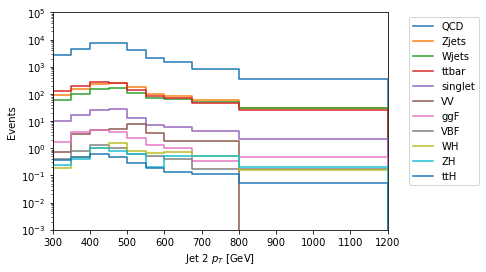

In [126]:
plot_overlay(x,'pt2')

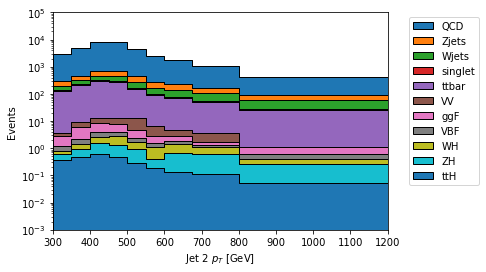

In [127]:
plot_stack(x,'pt2')

In [128]:
x = templates.sum('pt2', 'n2ddt2', 'msd1').integrate('ddb1',int_range=slice(0.89,1))

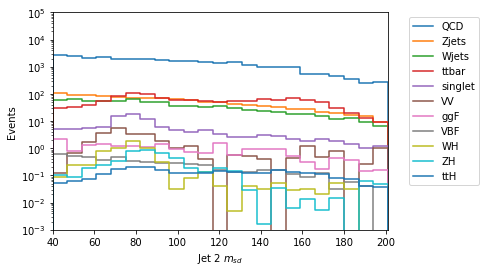

In [129]:
plot_overlay(x,'msd2')

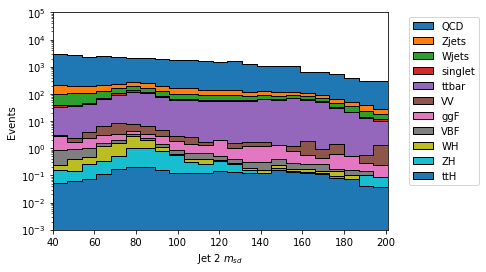

In [130]:
plot_stack(x,'msd2')

In [131]:
x = templates.sum('pt2','msd2','msd1').integrate('ddb1',int_range=slice(0.89,1))

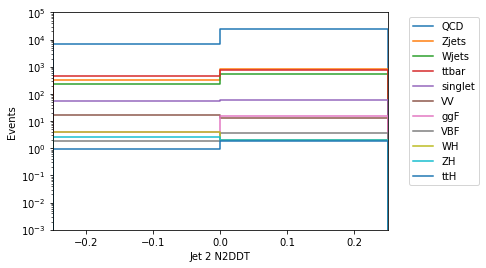

In [132]:
plot_overlay(x,'n2ddt2')

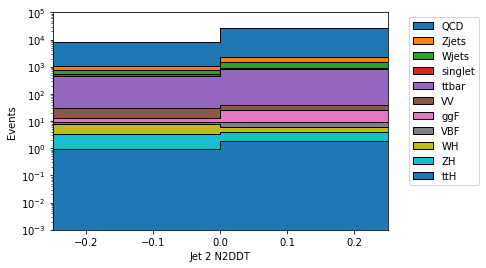

In [133]:
plot_stack(x,'n2ddt2')

In [134]:
x = templates.integrate('msd1',int_range=slice(mbb_min, mbb_max)).integrate('ddb1',int_range=slice(0.89,1))

In [135]:
if year == '2017':

    cuts3 = []
    sigs3 = []

    msd2_slices = [i*7+40 for i in range(1,23)]
    for msd2_min in msd2_slices:
        for msd2_max in msd2_slices:
            if msd2_max <= msd2_min:
                continue

            sliced = x.sum('pt2','n2ddt2').integrate('msd2',int_range=slice(msd2_min,msd2_max))
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs3 += [significance(s,b)]
            cuts3 += [[msd2_min,msd2_max]]
        
    cuts3 = np.array(cuts3)
    print(max(sigs3))
    print(cuts3[np.argmax(sigs3)])

    msd_min_vh = cuts3[np.argmax(sigs3)][0]
    msd_max_vh = cuts3[np.argmax(sigs3)][1]

    plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[21,21]);
    plt.xlabel('$msd_{min}$');
    plt.ylabel('$msd_{max}$');
    plt.savefig(year+'/plot-all/vh_2d_msdminmax.png')
    
else:
    msd2_min = 75
    msd2_max = 96

In [136]:
if year == '2017':

    cuts5 = []
    sigs5 = []

    pt2_slices = [300, 350, 400, 450, 500, 550, 600, 675, 800]
    n2ddt2_slices = [-0.25+0.25*i for i in range(1,3)]

    for pt2 in pt2_slices:
        for n2ddt2 in n2ddt2_slices:

            msd2_min = msd_min_vh
            msd2_max = msd_max_vh
        
            sliced = x.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs5 += [significance(s,b)]
            cuts5 += [[pt2,n2ddt2]]
        
    cuts5 = np.array(cuts5)
    print(max(sigs5))
    print(cuts5[np.argmax(sigs5)])

    n2ddt2_cut = cuts5[np.argmax(sigs5)][1]
    pt2_cut = cuts5[np.argmax(sigs5)][0]

    plt.hist2d(cuts5[:,0], cuts5[:,1], density=False, weights=sigs5, bins=[[300, 350, 400, 450, 500, 550, 600, 675, 800, 1200],[0,0.25,0.5]]);
    plt.xlabel('$p_{T}$');
    plt.ylabel('n2ddt');
    plt.savefig(year+'/plot-all/vh_2d_n2ddtpt.png')
    
else:
    pt2_cut = 550
    n2ddt2_cut = 0

{'ttH': [0.030532335428588016], 'ZH': [0.4933707748051784], 'WH': [0.8079276295212223], 'VBF': [0.023596118469869445], 'ggF': [0.07755050089900273], 'VV': [0.0], 'ttbar': [8.461738547856934], 'singlet': [1.618376958435923], 'Wjets': [1.3510424038352429], 'Zjets': [1.2615520283737198], 'QCD': [30.94471390443668]}


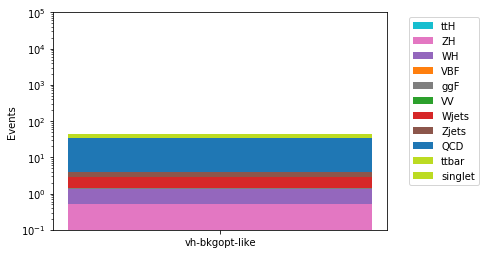

In [137]:
sr = x.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).values()
yield_plot(sr, 'vh-bkgopt')

In [138]:
# significance
s = sr[('WH',)] + sr[('ZH',)]
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)]  + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('VBF',)] + sr[('ttH',)]

print(s,b)
print(significance(s,b))

# this only makes sense in the mass window of Higgs

1.3012984043264006 43.769102797735954
0.19573211259942547


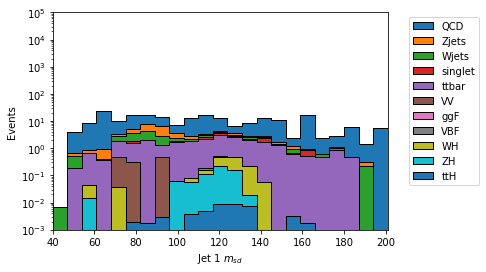

In [139]:
mhist = templates.integrate('ddb1',int_range=slice(0.89,1)).integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200))
plot_stack(mhist,'vh-msd1')

In [140]:
import pandas as pd

In [141]:
df1 = pd.DataFrame(index=['$V$ jet $m_{sd}$','$V$ jet N2DDT','$V$ jet $p_T$','$H$ jet DeepDoubleB'],columns=['ggF','VBF','WH','ZH','ttH'])
df2 = pd.DataFrame(index=['$V$ jet $m_{sd}$','$V$ jet N2DDT','$V$ jet $p_T$','$H$ jet DeepDoubleB'],columns=['QCD','Wjets','Zjets','VV','ttbar','singlet'])

In [142]:
# msd2 cut
tmp = templates.sum('msd1','pt2','n2ddt2','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).values()
cutname = '$V$ jet $m_{sd}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [143]:
# n2ddt2
tmp = templates.sum('msd1','pt2','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).values()
cutname = '$V$ jet N2DDT'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [144]:
# pt2
tmp = templates.sum('msd1','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).values()
cutname = '$V$ jet $p_T$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [145]:
# ddb1
tmp = templates.sum('msd1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).integrate('ddb1',int_range=slice(0.89,1)).values()
cutname = '$H$ jet DeepDoubleB'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [146]:
print(df1)
df1 = df1.astype('int')
df1.to_latex(buf=year+'/cutflow-sig.tex')

                           ggF        VBF        WH        ZH        ttH
$V$ jet $m_{sd}$       6.87483    1.86503   6.32529   4.74958    2.06813
$V$ jet N2DDT          2.13427   0.709565   4.18469   3.41447    1.20807
$V$ jet $p_T$         0.373734  0.0333578    1.4446     1.132   0.136727
$H$ jet DeepDoubleB  0.0775505  0.0235961  0.957751  0.626182  0.0504347


In [147]:
print(df2)
df2 = df2.astype('int')
df2.to_latex(buf=year+'/cutflow-bkg.tex')

                         QCD    Wjets    Zjets       VV    ttbar  singlet
$V$ jet $m_{sd}$      416691  9952.54  4702.24  363.542  2614.67   429.14
$V$ jet N2DDT        94611.6  4415.37  2147.48  247.638  1587.19  262.362
$V$ jet $p_T$        14511.7  854.649   447.19  60.2095  214.704   39.729
$H$ jet DeepDoubleB  165.248  10.9984  14.1709  1.23825  24.6055  2.41923


In [148]:
# Hard-coded -- combine results from all 3 years

VH = 0
tot_H = 0

#2016
VH += 0.576513 + 0.335428
tot_H += 0.00495358 + 0.0620203 + 0.576513 + 0.335428 + 0.0373796

#2017
VH += 1.62591 + 1.05862
tot_H += 0.223702 + 0.245804 + 1.62591 + 1.05862 + 0.159492

#2018
VH += 0.957751 + 0.626182
tot_H += 0.0775505 + 0.0235961 + 0.957751 + 0.626182 + 0.0504347

print(VH/tot_H)

0.8540999762918356


In [149]:
np.sqrt(.115**2 + .181**2 + .196**2)

0.29052022304824154